# WEP Source Selection With WCS

Owner: **Bryce Kalmbach** ([@jbkalmbach](https://github.com/lsst-ts/ts_analysis_notebooks/issues/new?body=@jbkalmbach))
<br>Last Verified to Run: **2022-02-14**
<br>Software Versions:
  - `ts_wep`: **v2.2.0**
  - `lsst_distrib`: **w_2022_06**

## Notebook Objective

This notebooks shows how to use the `generateDonutCatalogWcsTask` to create donut catalogs with a WCS available. It also shows how to configure the task with different source selector configurations. Finally, it shows how this task can be run as a part of a Gen 3 middleware pipeline.

## Logistics

This notebook is intended to be run on the RSP https://lsst-rsp-stable.ncsa.illinois.edu/nb. The data set is on NCSA.

## Imports

In [1]:
from lsst.daf.butler import Butler

from lsst.ts.wep.Utility import runProgram, writePipetaskCmd
from lsst.ts.wep.task.RefCatalogInterface import RefCatalogInterface
from lsst.ts.wep.task.GenerateDonutCatalogWcsTask import GenerateDonutCatalogWcsTaskConfig, GenerateDonutCatalogWcsTask

## Create `donutCatalog` as a single task before pipeline

In [2]:
# Repository with the raw data
butler_repo = '/project/aos/data_repos/aosTestDataRepo'

### Configure the `generateDonutCatalogWcsTask`

In [3]:
# Initialize Configuration
config = GenerateDonutCatalogWcsTaskConfig()

In [4]:
# Look at initial configuration
print(config)
print(config.keys())

{'saveMetadata': True, 'saveLogOutput': True, 'filterName': 'g', 'referenceSelector': {'doMagLimit': False, 'doFlags': False, 'doUnresolved': False, 'doSignalToNoise': False, 'doMagError': False, 'magLimit': {'minimum': None, 'maximum': None, 'fluxField': 'flux'}, 'flags': {'good': [], 'bad': []}, 'unresolved': {'minimum': None, 'maximum': 0.5, 'name': 'base_ClassificationExtendedness_value'}, 'signalToNoise': {'minimum': None, 'maximum': None, 'fluxField': 'flux', 'errField': 'flux_err'}, 'magError': {'minimum': None, 'maximum': None, 'magErrField': 'mag_err'}, 'colorLimits': {}}, 'donutSelector': {'xCoordField': 'centroid_x', 'yCoordField': 'centroid_y', 'fluxField': 'flux', 'donutRadius': 63.0, 'isoMagDiff': 2.0, 'sourceLimit': -1, 'maxBlended': 0}, 'doDonutSelection': True, 'connections': {'refCatalogs': 'cal_ref_cat', 'exposure': 'postISRCCD', 'donutCatalog': 'donutCatalog'}}
['saveMetadata', 'saveLogOutput', 'filterName', 'referenceSelector', 'donutSelector', 'doDonutSelection', 

In [5]:
# Set the name of the filter you will want in the final donut catalog
# NOTE: This does not set the flux fields in the source selector subtasks below so that it is possible to make
# cuts based upon star properties in different filters than the final catalog output. But this means that
# for every source selector subtask the `fluxField` must be defined as is shown below.
config.filterName = 'g'

* `referenceSelector`:

  * This is the subtask that performs initial cuts on the reference catalog selection.
  * This task is activated with `doReferenceSelection`.
  * In this example we will set the magnitude minimum and maximum values in `magLimit` in the filter specified by `magLimit.fluxField`. 
  * For more information on all the configuration settings available here see the class [`ReferenceSourceSelectorConfig`](https://github.com/lsst/meas_algorithms/blob/main/python/lsst/meas/algorithms/sourceSelector.py) in the `meas_algorithms` package.

In [6]:
# Activate magnitude limits
config.referenceSelector.doMagLimit = True
# Set the filter to use with the mag limit
config.referenceSelector.magLimit.fluxField = 'g_flux'
# Set magnitude limits
config.referenceSelector.magLimit.maximum = 17.
config.referenceSelector.magLimit.minimum = 13.

* `donutSelector`:

  * This is the subtask that performs cuts on the sources detected to get our donut sources.
  * This task is activated with `doDonutSelection`.
  * The default settings have `donutRadius` equal to 63. This means that sources will be tagged as unblended as long as they are 126 pixels from another source within the `isoMagDiff`. The `isoMagDiff` default is 2.0. This means that if multiple sources are within the `donutRadius` of each other but the brightest is at least `isoMagDiff` brighter in the filter specified by `fluxField` than any of the others we will consider the brightest source unblended.
  * Here we will set a maximum number of sources to return in the catalog with `sourceLimit`. This will return the `n` brightest, unblended sources within our catalog settings up to `n = sourceLimit`. If `sourceLimit` is set to -1 (which is the default) then it will return all sources.
  * Finally we also set the number of stars that we will accept to be blended with the brightest star in a group (remember blended means the stars are within `donutRadius` pixels of one another and their magnitudes are within `isoMagDiff`). When we set this config `maxBlended` to 0 we only accept unblended, isolated stars.

In [7]:
# Activate the subtask
config.doDonutSelection = True
# Set the filter we want to use for the donut selection (this is used with the isoMagDiff parameter).
config.donutSelector.fluxField = 'g_flux'
# Set the magnitude difference for stars to count as not blended with fainter, overlapping stars
config.donutSelector.isoMagDiff = 2.0
# Set the donut radius
config.donutSelector.donutRadius = 63.0
# Set source limit
config.donutSelector.sourceLimit = 3
# Set the number of stars that can be blended with a star. A value of 0 here means we only take unblended stars.
config.donutSelector.maxBlended = 0

## Create donut source catalogs

### Configure reference catalog input

Here we use the pointing information to only load the pieces of the reference catalog that cover the area of the sky in our field of view.

In [8]:
# Initialize with pointing information
boresightRa = 197.464413
boresightDec = 24.335542
boresightRotAng = 90.0
refCatInterface = RefCatalogInterface(boresightRa, boresightDec, boresightRotAng)

#### Get `shardIds` for pointing

In [9]:
%%time
htmIds = refCatInterface.getHtmIds()

CPU times: user 0 ns, sys: 475 µs, total: 475 µs
Wall time: 524 µs


In [10]:
htmIds

array([223876, 223889, 223890, 223891, 223896, 223897, 223898, 223899,
       223900, 223901, 223902, 223903, 223928, 223929, 223931, 224328,
       224353, 224356, 224358, 224359, 224366, 224372, 223877, 223878,
       223879, 223888, 223893, 223894, 223895, 223922, 223930, 223932,
       223933, 223935, 223952, 223954, 223955, 223961, 223965, 224329,
       224330, 224331, 224352, 224354, 224355, 224357, 224364, 224365,
       224367, 224373, 224374, 224375, 224382])

#### Get butler data references for the pieces of the reference catalogs we want

In [11]:
butler = Butler(butler_repo)
# Find the collection that holds the reference catalogs
list(butler.registry.queryCollections())

['refcats/DM-28636',
 'LSSTCam/raw/all',
 'LSSTCam/calib',
 'LSSTCam/calib/unbounded',
 'w_2022_06']

In [12]:
collections = ['refcats/DM-28636']

In [13]:
%%time
# Use the shardIds found above to get the locations (`dataRefs`) in the butler repo for the catalog pieces we want
catalogName = 'ps1_pv3_3pi_20170110'
dataRefs, dataIds = refCatInterface.getDataRefs(htmIds, butler, catalogName, collections)

CPU times: user 352 ms, sys: 31.2 ms, total: 383 ms
Wall time: 428 ms


In [14]:
# The butler dataset references for the pieces of the reference catalog we want
dataRefs[:5]

[DeferredDatasetHandle(butler=<lsst.daf.butler._butler.Butler object at 0x7fa464eb84c0>, ref=DatasetRef(DatasetType('ps1_pv3_3pi_20170110', {htm7}, SimpleCatalog), {htm7: 223876}, id=7e3ed85e-4749-4739-acc6-8d51ed523055, run='refcats/DM-28636'), parameters=None),
 DeferredDatasetHandle(butler=<lsst.daf.butler._butler.Butler object at 0x7fa464eb84c0>, ref=DatasetRef(DatasetType('ps1_pv3_3pi_20170110', {htm7}, SimpleCatalog), {htm7: 223889}, id=2c0006b8-4cae-4904-a8a9-16af16367280, run='refcats/DM-28636'), parameters=None),
 DeferredDatasetHandle(butler=<lsst.daf.butler._butler.Butler object at 0x7fa464eb84c0>, ref=DatasetRef(DatasetType('ps1_pv3_3pi_20170110', {htm7}, SimpleCatalog), {htm7: 223890}, id=7e8afd6e-dd3b-46b2-82e7-ae8e28eaff8f, run='refcats/DM-28636'), parameters=None),
 DeferredDatasetHandle(butler=<lsst.daf.butler._butler.Butler object at 0x7fa464eb84c0>, ref=DatasetRef(DatasetType('ps1_pv3_3pi_20170110', {htm7}, SimpleCatalog), {htm7: 223891}, id=8987c231-a604-4d7f-b7b8-5

### Run ISR and get images

Before we go any further let's process some images so we can plot our catalogs on the images and see what our results look like at each step.

In [15]:
from lsst.ip.isr.isrTask import IsrTask, IsrTaskConfig

In [16]:
isrConfig = IsrTaskConfig()

In [17]:
isrConfig.doBias = False
isrConfig.doVariance = False
isrConfig.doLinearize = False
isrConfig.doCrosstalk = False
isrConfig.doDefect = False
isrConfig.doNanMasking = False
isrConfig.doInterpolate = False
isrConfig.doDark = False
isrConfig.doFlat = False
isrConfig.doApplyGains = True
isrConfig.doFringe = False
isrConfig.doOverscan = True

In [18]:
isrTask = IsrTask(config=isrConfig)

In [19]:
cwfsDataIdsExtra = list(butler.registry.queryDataIds(['exposure', 'detector', 'instrument'], detector=191, instrument='LSSTCam'))

In [20]:
cwfsDataIdsExtra[2]

{instrument: 'LSSTCam', detector: 191, exposure: 4021123110021, ...}

In [21]:
cwfsDataIdsIntra = list(butler.registry.queryDataIds(['exposure', 'detector', 'instrument'], detector=192, instrument='LSSTCam'))

In [22]:
cwfsDataIdsIntra

[{instrument: 'LSSTCam', detector: 192, exposure: 4021123110121, ...},
 {instrument: 'LSSTCam', detector: 192, exposure: 4021123110221, ...},
 {instrument: 'LSSTCam', detector: 192, exposure: 4021123110021, ...}]

In [23]:
exposureExtra = butler.get('raw', dataId=cwfsDataIdsExtra[2], collections=['LSSTCam/raw/all'])

In [24]:
exposureIntra = butler.get('raw', dataId=cwfsDataIdsIntra[2], collections=['LSSTCam/raw/all'])

In [25]:
isrOutExtra = isrTask.run(exposureExtra)

In [26]:
isrOutIntra = isrTask.run(exposureIntra)

### Running with the initial catalog configuration

In [27]:
# Run task
catCreationTask = GenerateDonutCatalogWcsTask(config=config)

In [28]:
catExtra = catCreationTask.run(dataRefs, isrOutExtra.exposure)

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

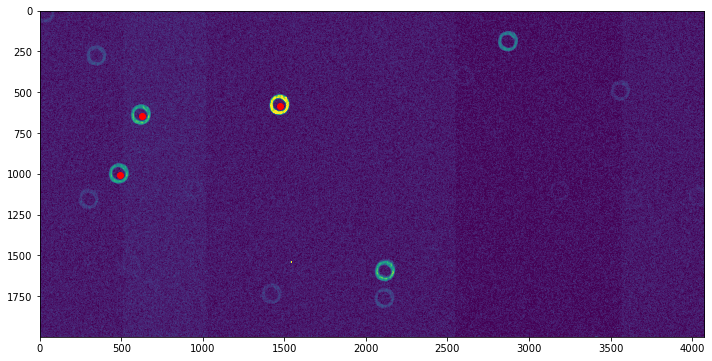

In [30]:
fig = plt.figure(figsize=(12, 6))
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10)
plt.scatter(catExtra.donutCatalog['centroid_x'], catExtra.donutCatalog['centroid_y'], c='r')

### Show that our catalog changes as we change configurations

Let's change the configuration settings and see how our catalog changes.

#### Remove limit on number of sources

In [31]:
# Create task with our configuration from above but first turn off the sourceLimit parameter (set to -1).
config.donutSelector.sourceLimit = -1
catCreationTask = GenerateDonutCatalogWcsTask(config=config)

In [32]:
%%time
catExtraNoSourceLimit = catCreationTask.run(dataRefs, isrOutExtra.exposure)

CPU times: user 490 ms, sys: 6.08 ms, total: 496 ms
Wall time: 564 ms


In [33]:
catExtraNoSourceLimit.donutCatalog

coord_ra  coord_dec   centroid_x   centroid_y   source_flux
0  3.425477   0.404431  1473.278069   585.437638  5.701143e+06
1  3.425024   0.405381   489.555297  1006.829675  2.894765e+06
2  3.425405   0.405252   625.051257   646.687817  1.631603e+06
3  3.425588   0.402410  3559.659720   498.353154  6.068564e+05

We see that we now have one more source than we had when we limited the length of the returned catalog.

Text(0.5, 1.0, 'Source Limit removed')

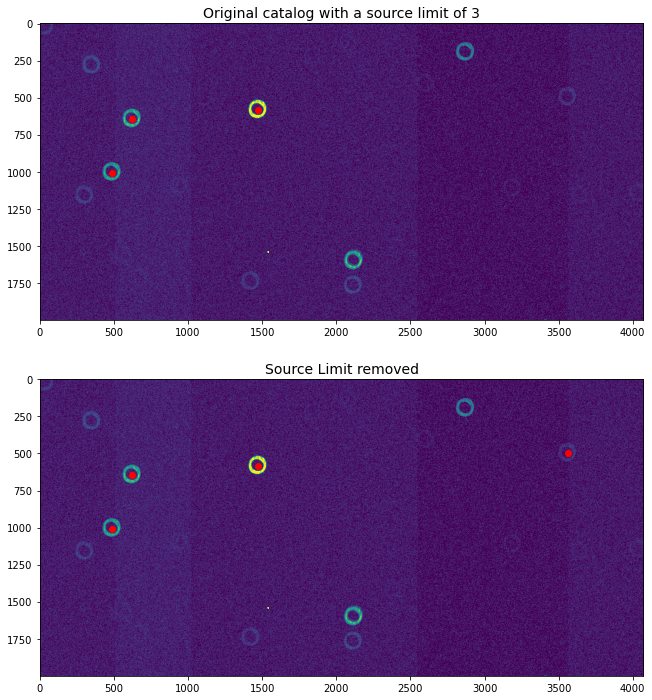

In [34]:
fig = plt.figure(figsize=(12, 12))
fig.add_subplot(2,1,1)
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10)
plt.scatter(catExtra.donutCatalog['centroid_x'], catExtra.donutCatalog['centroid_y'], c='r')
plt.title('Original catalog with a source limit of 3', size=14)

fig.add_subplot(2,1,2)
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10)
plt.scatter(catExtraNoSourceLimit.donutCatalog['centroid_x'], catExtraNoSourceLimit.donutCatalog['centroid_y'], c='r')
plt.title('Source Limit removed', size=14)

Notice how the sources kept with the `sourceLimit` are the `sourceLimit` brightest sources.

#### Change magnitude limits

In [35]:
# Change magLimit maximum value to 19.0 from 17.0
config.referenceSelector.magLimit.maximum = 19.0
catCreationTask = GenerateDonutCatalogWcsTask(config=config)

In [36]:
%%time
catExtraMagLimit19 = catCreationTask.run(dataRefs, isrOutExtra.exposure)

CPU times: user 544 ms, sys: 5.93 ms, total: 550 ms
Wall time: 642 ms


In [37]:
catExtraMagLimit19.donutCatalog

coord_ra  coord_dec   centroid_x   centroid_y   source_flux
0  3.425477   0.404431  1473.278069   585.437638  5.701143e+06
1  3.425024   0.405381   489.555297  1006.829675  2.894765e+06
2  3.425405   0.405252   625.051257   646.687817  1.631603e+06
3  3.425588   0.402410  3559.659720   498.353154  6.068564e+05
4  3.424858   0.405559   303.930067  1163.140206  4.078495e+05
5  3.425783   0.405519   352.532540   285.811952  3.712149e+05
6  3.424258   0.404468  1425.129471  1741.745063  3.166788e+05
7  3.424238   0.403799  2114.693355  1767.319005  2.004627e+05
8  3.424938   0.402767  3185.479045  1112.658530  1.950485e+05
9  3.425674   0.403338  2602.381158   408.767115  1.019323e+05

Now we have a lot more sources. Let's check the magnitudes from each catalog to make sure the cuts are correct.

In [38]:
import numpy as np
import astropy.units as u
origCatalogMags = (catExtraNoSourceLimit.donutCatalog['source_flux'].values * u.nJy).to_value(u.ABmag)
newCatalogMags = (catExtraMagLimit19.donutCatalog['source_flux'].values * u.nJy).to_value(u.ABmag)

In [39]:
print(f"The original catalog had stars with magnitudes between {np.min(origCatalogMags)} and {np.max(origCatalogMags)}.\nThese are within the limits of 13.0 - 17.0 set by the task configuration.")

The original catalog had stars with magnitudes between 14.510095107864963 and 16.942285217797046.
These are within the limits of 13.0 - 17.0 set by the task configuration.


In [40]:
print(f"The new catalog has stars with magnitudes between {np.min(newCatalogMags)} and {np.max(newCatalogMags)}.\nThese are within the limits of 13.0 - 19.0 set by the task configuration.")

The new catalog has stars with magnitudes between 14.510095107864963 and 18.879220412513288.
These are within the limits of 13.0 - 19.0 set by the task configuration.


Text(0.5, 1.0, 'Mag Limit maximum increased to 19.0 from 17.0')

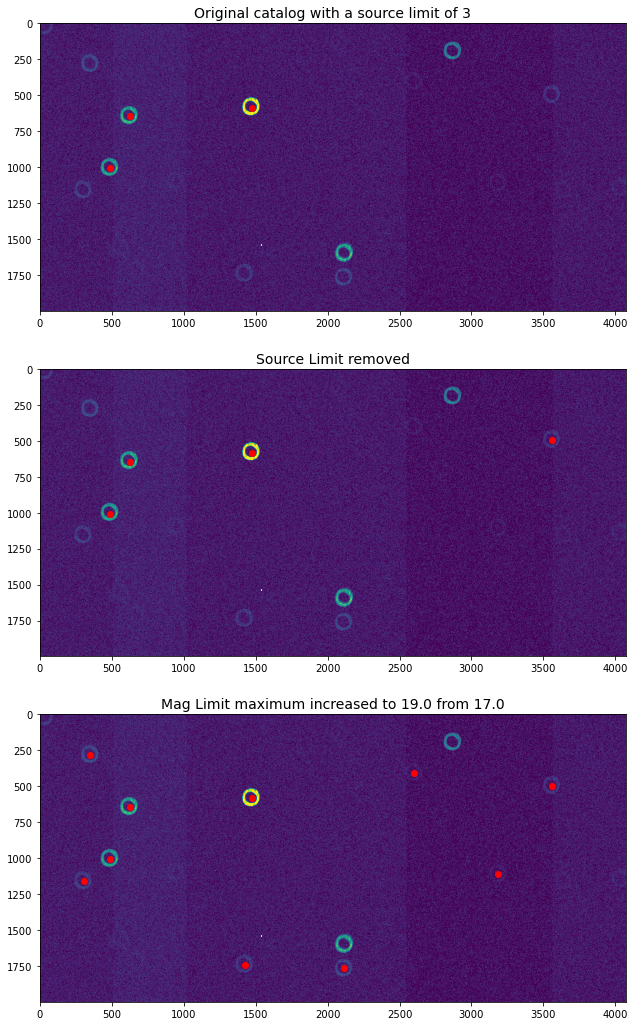

In [41]:
fig = plt.figure(figsize=(12, 18))
fig.add_subplot(3,1,1)
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10)
plt.scatter(catExtra.donutCatalog['centroid_x'], catExtra.donutCatalog['centroid_y'], c='r')
plt.title('Original catalog with a source limit of 3', size=14)

fig.add_subplot(3,1,2)
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10)
plt.scatter(catExtraNoSourceLimit.donutCatalog['centroid_x'], catExtraNoSourceLimit.donutCatalog['centroid_y'], c='r')
plt.title('Source Limit removed', size=14)

fig.add_subplot(3,1,3)
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10)
plt.scatter(catExtraMagLimit19.donutCatalog['centroid_x'], catExtraMagLimit19.donutCatalog['centroid_y'], c='r')
plt.title('Mag Limit maximum increased to 19.0 from 17.0', size=14)

#### Change isolated magnitude setting

Let's call stars unblended now if there are only 1 magnitude brighter than any overlapping stars.

In [42]:
# Change isoMagDiff to shrink the threshold for unblended down to only 1 magnitude brighther than overlapping stars
config.donutSelector.isoMagDiff = 1.0
catCreationTask = GenerateDonutCatalogWcsTask(config=config)

In [43]:
%%time
catExtraIsoOneMag = catCreationTask.run(dataRefs, isrOutExtra.exposure)

CPU times: user 620 ms, sys: 12.1 ms, total: 632 ms
Wall time: 772 ms


In [44]:
catExtraIsoOneMag.donutCatalog

coord_ra  coord_dec   centroid_x   centroid_y   source_flux
0   3.425477   0.404431  1473.278069   585.437638  5.701143e+06
1   3.425024   0.405381   489.555297  1006.829675  2.894765e+06
2   3.425405   0.405252   625.051257   646.687817  1.631603e+06
3   3.424412   0.403798  2117.701930  1602.176935  6.126991e+05
4   3.425588   0.402410  3559.659720   498.353154  6.068564e+05
5   3.424858   0.405559   303.930067  1163.140206  4.078495e+05
6   3.425783   0.405519   352.532540   285.811952  3.712149e+05
7   3.424258   0.404468  1425.129471  1741.745063  3.166788e+05
8   3.424238   0.403799  2114.693355  1767.319005  2.004627e+05
9   3.424938   0.402767  3185.479045  1112.658530  1.950485e+05
10  3.424483   0.405094   781.200548  1522.179860  1.502540e+05
11  3.425674   0.403338  2602.381158   408.767115  1.019323e+05

This setting allowed two more stars to pass through into our catalog.

Text(0.5, 1.0, 'Isolated Star Magnitude Difference reduced from 2.0 to 1.0 mags')

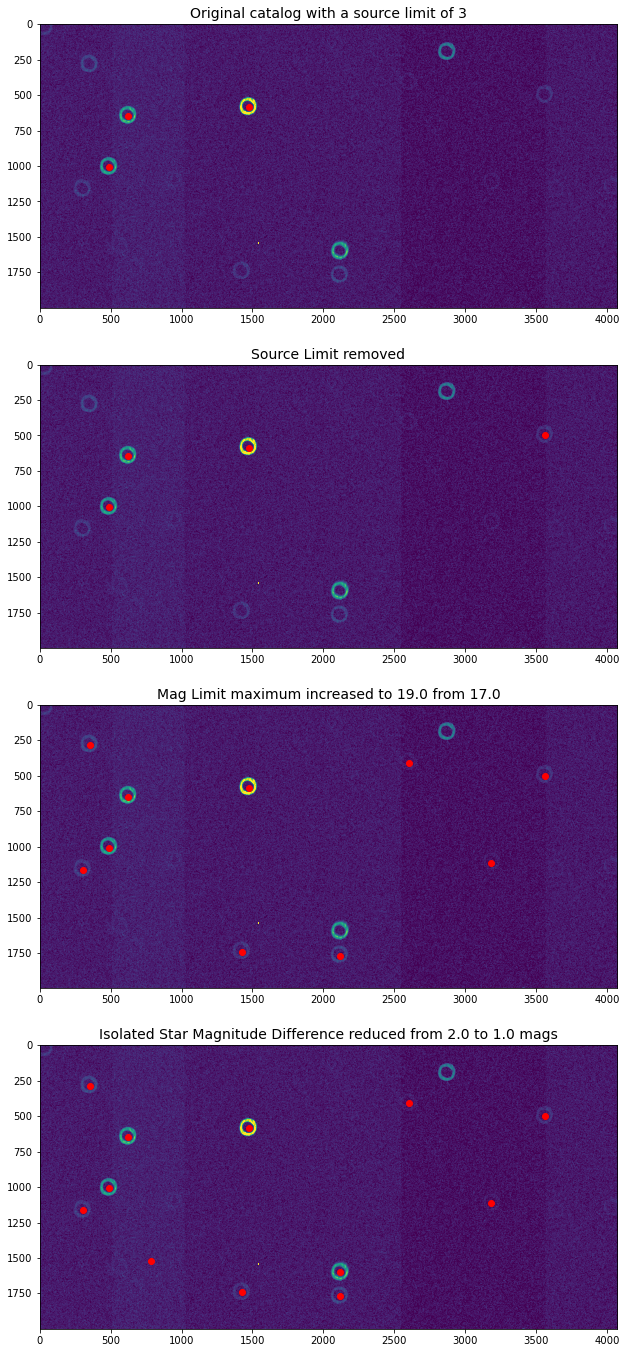

In [45]:
fig = plt.figure(figsize=(12, 24))
fig.add_subplot(4,1,1)
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10)
plt.scatter(catExtra.donutCatalog['centroid_x'], catExtra.donutCatalog['centroid_y'], c='r')
plt.title('Original catalog with a source limit of 3', size=14)

fig.add_subplot(4,1,2)
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10)
plt.scatter(catExtraNoSourceLimit.donutCatalog['centroid_x'], catExtraNoSourceLimit.donutCatalog['centroid_y'], c='r')
plt.title('Source Limit removed', size=14)

fig.add_subplot(4,1,3)
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10)
plt.scatter(catExtraMagLimit19.donutCatalog['centroid_x'], catExtraMagLimit19.donutCatalog['centroid_y'], c='r')
plt.title('Mag Limit maximum increased to 19.0 from 17.0', size=14)

fig.add_subplot(4,1,4)
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10)
plt.scatter(catExtraIsoOneMag.donutCatalog['centroid_x'], catExtraIsoOneMag.donutCatalog['centroid_y'], c='r')
plt.title('Isolated Star Magnitude Difference reduced from 2.0 to 1.0 mags', size=14)

#### Change number of allowed blended stars

Finally allow stars blended with only one other star within the `donutRadius` and `isoMagDiff` settings.

In [46]:
# Change number of allowed stars blended with a target star to be 1 instead of 0
config.donutSelector.maxBlended = 1
catCreationTask = GenerateDonutCatalogWcsTask(config=config)

In [47]:
%%time
catExtraOneBlend = catCreationTask.run(dataRefs, isrOutExtra.exposure)

CPU times: user 635 ms, sys: 62.3 ms, total: 698 ms
Wall time: 1.79 s


In [48]:
catExtraOneBlend.donutCatalog

coord_ra  coord_dec   centroid_x   centroid_y   source_flux
0   3.425477   0.404431  1473.278069   585.437638  5.701143e+06
1   3.425024   0.405381   489.555297  1006.829675  2.894765e+06
2   3.425899   0.403078  2872.042347   197.019891  1.805189e+06
3   3.425405   0.405252   625.051257   646.687817  1.631603e+06
4   3.424412   0.403798  2117.701930  1602.176935  6.126991e+05
5   3.425588   0.402410  3559.659720   498.353154  6.068564e+05
6   3.424858   0.405559   303.930067  1163.140206  4.078495e+05
7   3.425783   0.405519   352.532540   285.811952  3.712149e+05
8   3.424258   0.404468  1425.129471  1741.745063  3.166788e+05
9   3.424238   0.403799  2114.693355  1767.319005  2.004627e+05
10  3.424938   0.402767  3185.479045  1112.658530  1.950485e+05
11  3.424483   0.405094   781.200548  1522.179860  1.502540e+05
12  3.425674   0.403338  2602.381158   408.767115  1.019323e+05
13  3.424437   0.405304   563.499263  1563.816232  9.808326e+04

Once again two more sources appear in our catalog.

Text(0.5, 1.0, 'Allowed number of blended neighbors increased from 0 to 1.')

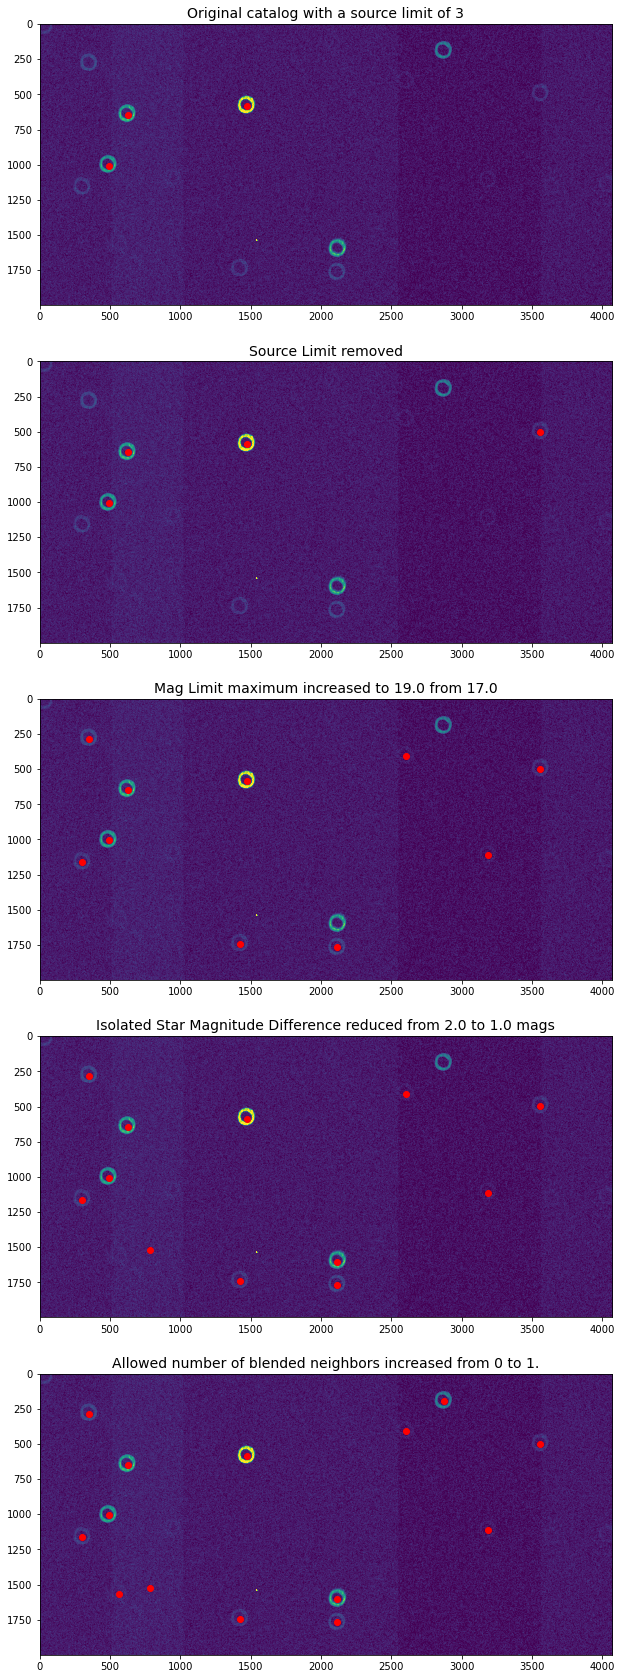

In [49]:
fig = plt.figure(figsize=(12, 30))
fig.add_subplot(5,1,1)
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10)
plt.scatter(catExtra.donutCatalog['centroid_x'], catExtra.donutCatalog['centroid_y'], c='r')
plt.title('Original catalog with a source limit of 3', size=14)

fig.add_subplot(5,1,2)
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10)
plt.scatter(catExtraNoSourceLimit.donutCatalog['centroid_x'], catExtraNoSourceLimit.donutCatalog['centroid_y'], c='r')
plt.title('Source Limit removed', size=14)

fig.add_subplot(5,1,3)
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10)
plt.scatter(catExtraMagLimit19.donutCatalog['centroid_x'], catExtraMagLimit19.donutCatalog['centroid_y'], c='r')
plt.title('Mag Limit maximum increased to 19.0 from 17.0', size=14)

fig.add_subplot(5,1,4)
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10)
plt.scatter(catExtraIsoOneMag.donutCatalog['centroid_x'], catExtraIsoOneMag.donutCatalog['centroid_y'], c='r')
plt.title('Isolated Star Magnitude Difference reduced from 2.0 to 1.0 mags', size=14)

fig.add_subplot(5,1,5)
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10)
plt.scatter(catExtraOneBlend.donutCatalog['centroid_x'], catExtraOneBlend.donutCatalog['centroid_y'], c='r')
plt.title('Allowed number of blended neighbors increased from 0 to 1.', size=14)

#### What's going on with the the bright source in the top right?

There seems to be a source in the top of the chip that is not accepted by the source selector until the last change in the configuration 
but it looks like an isolated source that is bright enough to get through earlier. 
What is going on with this source? Let's take a look.

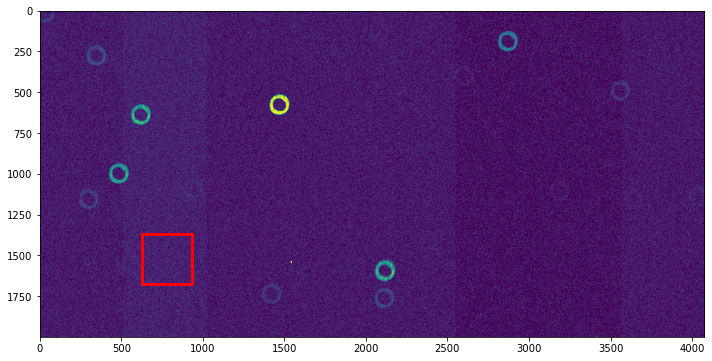

In [50]:
fig = plt.figure(figsize=(12, 6))
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10)
plt.plot(catExtraOneBlend.donutCatalog['centroid_x'].iloc[11], catExtraOneBlend.donutCatalog['centroid_y'].iloc[11], '-s', c='r', markeredgewidth=3, markersize=50, fillstyle='none')

To take a closer look let's load the complete reference catalog information for this chip.

In [51]:
completeRefCat = catCreationTask.getRefObjLoader(dataRefs).loadPixelBox(
    isrOutExtra.exposure.getBBox(), isrOutExtra.exposure.getWcs(), filterName='g', bboxToSpherePadding=0
)

In [52]:
completeRefCat

Struct(refCat=        id              coord_ra      ...  slot_Centroid_y   hasCentroid
                          rad         ...                               
------------------ ------------------ ... ------------------ -----------
135901961811583268  3.424004382926665 ... 1969.4849024203068        True
135901961812381586 3.4240062093390433 ... 1967.9851271346415        True
135741961816424246 3.4240158800450637 ... 1980.6314425364762        True
135731961822099701  3.424026631028441 ... 1971.0584107318355        True
135781961823654477  3.424029213594816 ... 1962.4275500824006        True
135791961827656157   3.42403429433225 ...  1955.958290789651        True
135791961854678349 3.4240840236411554 ... 1908.4823859113749        True
135681961884479289  3.424135570734581 ...  1874.602406899543        True
135661961888594716 3.4241410421388507 ... 1872.7913293955753        True
135781961889259176 3.4241424834096206 ... 1854.2649810879157        True
               ...                ...

(300.0, 100.0)

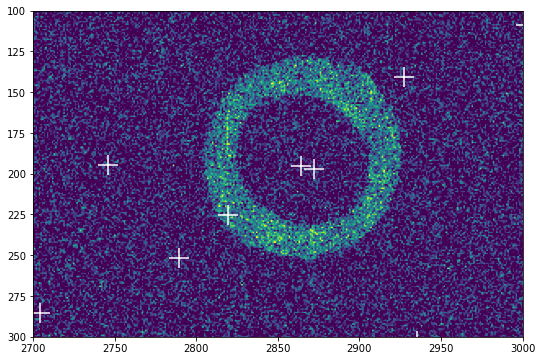

In [53]:
fig = plt.figure(figsize=(12, 6))
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10)
plt.plot(catExtraOneBlend.donutCatalog['centroid_x'].iloc[11], catExtraOneBlend.donutCatalog['centroid_y'].iloc[11], '-s', c='r', markeredgewidth=3, markersize=50, fillstyle='none')
plt.scatter(completeRefCat.refCat['centroid_x'], completeRefCat.refCat['centroid_y'], c='w', marker='+', s=400)
plt.xlim((2700, 3000))
plt.ylim((300, 100))

We can now see that there are two sources almost directly on top of each other. As long as the magnitudes of the two sources are within minMagDiff then the source selector is behaving correctly. Let's verify the magnitudes as a final check.

In [54]:
overlapIdx = np.where(((completeRefCat.refCat['centroid_x'] < 2900) & (completeRefCat.refCat['centroid_x'] > 2850) & (completeRefCat.refCat['centroid_y'] < 250)))
overlapFlux = completeRefCat.refCat.asAstropy()[overlapIdx]['g_flux']
print(overlapFlux.to(u.ABmag))

[15.75869319 16.4518976 ] mag(AB)


Here we see that the two sources are in fact within 1 magnitude of one another so the source selector was correct to exclude them until the last step.

In [55]:
# Run task
wcsTask = GenerateDonutCatalogWcsTask(config=config)

In [56]:
wcsCatExtra = wcsTask.run(dataRefs, isrOutExtra.exposure).donutCatalog

In [57]:
wcsCatExtra

coord_ra  coord_dec   centroid_x   centroid_y   source_flux
0   3.425477   0.404431  1473.278069   585.437638  5.701143e+06
1   3.425024   0.405381   489.555297  1006.829675  2.894765e+06
2   3.425899   0.403078  2872.042347   197.019891  1.805189e+06
3   3.425405   0.405252   625.051257   646.687817  1.631603e+06
4   3.424412   0.403798  2117.701930  1602.176935  6.126991e+05
5   3.425588   0.402410  3559.659720   498.353154  6.068564e+05
6   3.424858   0.405559   303.930067  1163.140206  4.078495e+05
7   3.425783   0.405519   352.532540   285.811952  3.712149e+05
8   3.424258   0.404468  1425.129471  1741.745063  3.166788e+05
9   3.424238   0.403799  2114.693355  1767.319005  2.004627e+05
10  3.424938   0.402767  3185.479045  1112.658530  1.950485e+05
11  3.424483   0.405094   781.200548  1522.179860  1.502540e+05
12  3.425674   0.403338  2602.381158   408.767115  1.019323e+05
13  3.424437   0.405304   563.499263  1563.816232  9.808326e+04

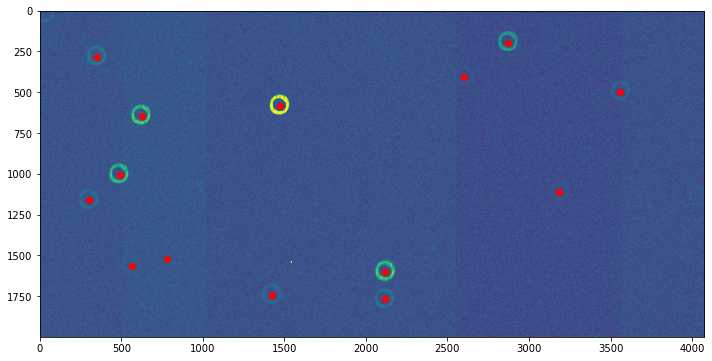

In [58]:
from matplotlib import pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(12, 6))
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=0)
plt.scatter(wcsCatExtra['centroid_x'], wcsCatExtra['centroid_y'], c='r')

Here you can see we get the same result as our first donut catalog when running with `GenerateDonutCatalogOnlineTask` at the start of the notebook.

## Running as a pipeline task

Here in this example notebook we showed how to run the `GenerateDonutCatalogWcsTask` in individual steps. When running in a full Gen3 processing pipeline you can use `GenerateDonutCatalogWcsTask` setting the configuration settings for source selection in a pipeline file or on the command line.

A sample pipeline configuration file to run the `isrTask` and `generateDonutCatalogWcsTask` from this notebook might look like this:
```
# This yaml file is used to define the tasks and configuration of
# a Gen 3 pipeline to run donut source selection using ts_wep
description: wep sample source selection pipeline
# Here we specify the corresponding instrument for the data we
# will be using.
instrument: lsst.obs.lsst.LsstCam
# Then we can specify each task in our pipeline by a name
# and then specify the class name corresponding to that task
tasks:
  isr:
    class: lsst.ip.isr.isrTask.IsrTask
    # Below we specify the configuration settings we want to use
    # when running the task in this pipeline. Since our data doesn't
    # include bias or flats we only want to use doApplyGains and
    # doOverscan in our isr task.
    config:
      connections.outputExposure: 'postISRCCD'
      doBias: False
      doVariance: False
      doLinearize: False
      doCrosstalk: False
      doDefect: False
      doNanMasking: False
      doInterpolate: False
      doBrighterFatter: False
      doDark: False
      doFlat: False
      doApplyGains: True
      doFringe: False
      doOverscan: True
  generateDonutCatalogWcsTask:
    class: lsst.ts.wep.task.GenerateDonutCatalogWcsTask.GenerateDonutCatalogWcsTask
    # Here we specify the configurations for pointing that we added into the class
    # GenerateDonutCatalogWcsTaskConfig.
    config:
      connections.refCatalogs: 'ps1_pv3_3pi_20170110'
      filterName: 'g'
      referenceSelector.doMagLimit: True
      referenceSelector.magLimit.maximum: 15.90
      referenceSelector.magLimit.minimum: 8.74
      referenceSelector.magLimit.fluxField: 'g_flux'
      doDonutSelection: True
      donutSelector.fluxField: 'g_flux'
```

And a possible entry on the command line would be:

`pipetask run -b $PATH_TO_BUTLER_REPO -i $COLLECTION_NAMES -d "exposure in ($EXPOSURE_IDS)" -p $PIPELINE_CONFIGURATION_FILE --instrument lsst.obs.lsst.LsstCam  --register-dataset-types --output-run $OUTPUT_RUN_NAME `

* `-b` points to your repository
* `-i` names the collections where your calibration and raw data are located in the repository
* `-d` specify a data selection query here
* `-p` the path to the configuration file like the sample above
* `--instrument` specify the instrument for your data
* `--register-dataset-types` registers any dataset types that don't already exist in the registry
* `--output-run` specifies the name of the new output collection